In [1]:
# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
from typing import Dict
from os.path import join as pjoin
import matplotlib.pyplot as plt


# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# Louvain etc
import community as community_louvain
from cdlib import algorithms

# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
rng = np.random.RandomState(RANDOM_STATE)

In [2]:
def community_layout(g: nx.Graph(), partition: Dict[int, int]):
    """
    Compute the layout for a modular graph.

    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)
    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos


def _position_communities(g, partition, **kwargs):
    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos


def _find_between_community_edges(g, partition):
    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges


def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos


def plot_graph(
        g: nx.Graph(),
        partition_pred: Dict[int, int],
        partition_true: Dict[int, int] = None,
        cmap: str = 'Accent',
        figsize=(13.5, 6), ):

    if partition_true is not None:
        pos = community_layout(g, partition_true)
    else:
        pos = community_layout(g, partition_pred)

    plt.figure(figsize=figsize)

    plt.subplot(121)
    plt.axis('off')
    nx.draw_networkx_nodes(
        g, pos, node_size=130, edgecolors='k', cmap=cmap, node_color=list(partition_true.values()))
    nx.draw_networkx_edges(g, pos, alpha=0.1)
    plt.title('True', fontsize=15)

    plt.subplot(122)
    plt.axis('off')
    nx.draw_networkx_nodes(
        g, pos, node_size=130, edgecolors='k', cmap=cmap, node_color=list(partition_pred.values()))
    nx.draw_networkx_edges(g, pos, alpha=0.1)
    plt.title('Pred', fontsize=15)

    plt.tight_layout()
    plt.show()

    return

## Load LFR

In [3]:
lfr_ws = 'Documents/workspaces/lfr/weighted_overlapping/networks'
lfr_ws = pjoin(os.environ['HOME'], lfr_ws)
network_name = 'small'

load_dir = pjoin(lfr_ws, network_name)
os.listdir(load_dir)

['community.dat', 'statistics.dat', 'network.dat']

In [31]:
# load network
g = nx.read_weighted_edgelist(pjoin(load_dir, 'network.dat'), nodetype=int)

# make ordered
sg = nx.OrderedGraph()
sg.add_nodes_from(sorted(g.nodes()))
sg.add_edges_from((u, v, d) for (u, v, d) in g.edges(data=True) if u in sg if v in sg)

# relable nodes to start indexing from 0
g = nx.relabel_nodes(
    G=sg,
    mapping={i: i - 1 for i in range(1, sg.order() + 1)},
    copy=True,
)

# get adjacency matrix
a = nx.adjacency_matrix(g).toarray()


# load memberships

with open(pjoin(load_dir, 'community.dat'), 'r') as f:
    lines = f.readlines()

membership_true = dict()
for line in lines:
    node, mem = line.strip('\n').split('\t')
    node = int(node) - 1
    membership_true[node] = list(int(x) - 1 for x in filter(None, mem.split(' ')))


# get communities and partition_true

membership_list = list(membership_true.values())
num_communities = max([max(x) for x in membership_list]) + 1
community_true = {
    i: list(itertools.compress(
        data=range(len(membership_list)),
        selectors=[i in x for x in membership_list]
    ))
    for i in range(num_communities)
}
partition_true = {
    n: rng.choice(mem) if len(mem) else -1
    for n, mem in membership_true.items()
}


# get num overlapping nodes
num_overlap_nodes = len(list(filter(lambda x: len(x) > 1, membership_true.values())))

print('Num true communities: {:d}\nNum overlapping nodes: {:d}'.format(len(community_true), num_overlap_nodes))

Num true communities: 3
Num overlapping nodes: 0


#### Use Louvain algorithm to detect communities

The communities in this network are highly disjoint and Louvain is expected to recover ground truth.

In [32]:
partition_pred = community_louvain.best_partition(g, resolution=1.0, random_state=RANDOM_STATE)
# partition_pred = dict(sorted(partition_pred.items()))

membership_pred = {n: [i] for n, i in partition_pred.items()}
membership_list = list(membership_pred.values())
num_communities = max([max(x) for x in membership_list]) + 1
community_pred = {
    i: list(itertools.compress(
        data=range(len(membership_list)),
        selectors=[i in x for x in membership_list]
    ))
    for i in range(num_communities)
}

#### Plot results

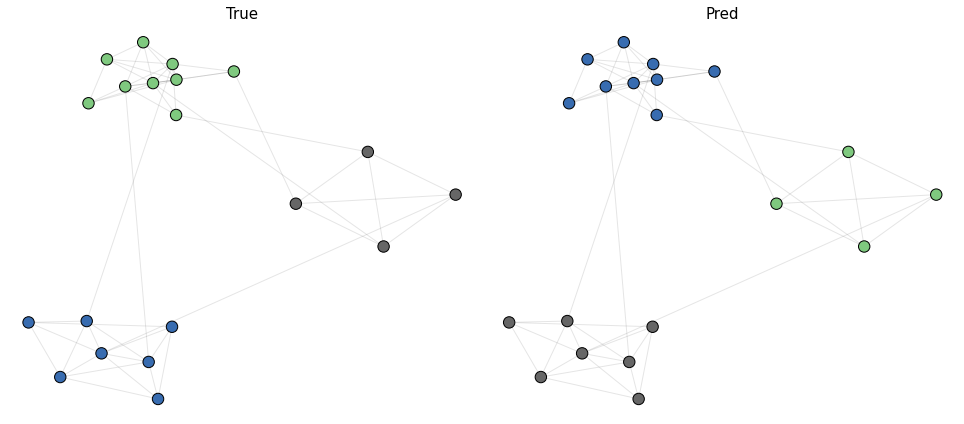

In [33]:
plot_graph(g, partition_pred=partition_pred, partition_true=partition_true)

In [36]:
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score


true_list = list(partition_true.values())
pred_list = list(partition_pred.values())

ami = adjusted_mutual_info_score(
    labels_true=true_list,
    labels_pred=pred_list,
)
nmi = normalized_mutual_info_score(
    labels_true=true_list,
    labels_pred=pred_list,
)

print('NMI: {:.4f}\nAMI: {:.4f}'.format(nmi, ami))

NMI: 1.0000
AMI: 1.0000


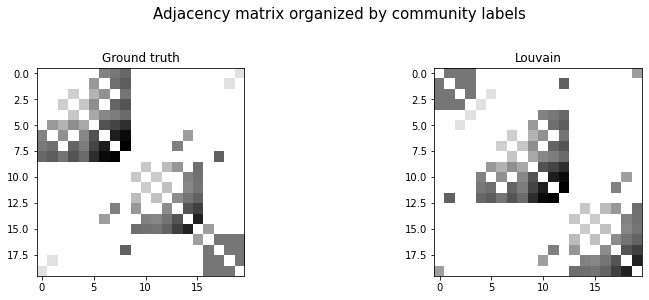

In [37]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
idxs = np.concatenate(list(community_true.values()))
plt.imshow(a[idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Ground truth')

plt.subplot(122)
idxs = np.concatenate(list(community_pred.values()))
plt.imshow(a[idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Louvain')

plt.suptitle('Adjacency matrix organized by community labels', fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

In [38]:
partition_pred

{0: 0,
 1: 1,
 2: 0,
 3: 2,
 4: 0,
 5: 1,
 6: 2,
 7: 2,
 8: 0,
 9: 1,
 10: 2,
 11: 2,
 12: 1,
 13: 1,
 14: 2,
 15: 1,
 16: 1,
 17: 2,
 18: 1,
 19: 1}

In [39]:
partition_true

{0: 2,
 1: 0,
 2: 2,
 3: 1,
 4: 2,
 5: 0,
 6: 1,
 7: 1,
 8: 2,
 9: 0,
 10: 1,
 11: 1,
 12: 0,
 13: 0,
 14: 1,
 15: 0,
 16: 0,
 17: 1,
 18: 0,
 19: 0}

## Generate similar network using nx

Networkx has an implementation of the LFR benchmark graph.  Here I will show that the ground truth reported in networkx implementation is correct.  Unfortunately, it is only for unweighted, nonoverlapping graphs.  Below I generate a similar non-overlapping network.

In [10]:
g = nx.LFR_benchmark_graph(
    n=20,
    tau1=3,
    tau2=1.7,
    mu=0.1,
    average_degree=5,
    max_degree=10,
    min_community=5,
    max_iters=500,
    seed=RANDOM_STATE,
)
a = nx.adjacency_matrix(g).toarray()

In [11]:
community_true = {frozenset(g.nodes[v]["community"]) for v in g}
community_true = {idx: list(comm) for idx, comm in enumerate(community_true)}
partition_true = {v: next(filter(lambda x: v in x[1], community_true.items()))[0] for v in g}

len(community_true)

3

#### Use Louvain algorithm to detect communities

The communities in this network are highly disjoint and Louvain is expected to recover ground truth.

In [12]:
partition_pred = community_louvain.best_partition(g, resolution=1.0, random_state=RANDOM_STATE)

membership_pred = {n: [i] for n, i in partition_pred.items()}
membership_list = list(membership_pred.values())
num_communities = max([max(x) for x in membership_list]) + 1
community_pred = {
    i: list(itertools.compress(
        data=range(len(membership_list)),
        selectors=[i in x for x in membership_list]
    ))
    for i in range(num_communities)
}

#### Plot results

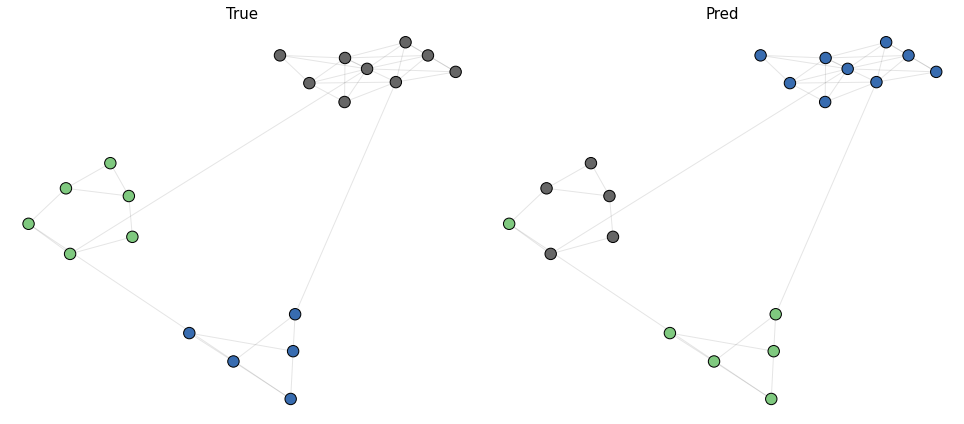

In [13]:
plot_graph(g, partition_pred=partition_pred, partition_true=partition_true)

Louvain uncovers the true community structure which matches ground truth labels generated by nx.LFR_benchmark_graph

#### Quantitative comparison 

Compute normalized_mutual_info between ground truth as returned by the benchmark code, and the partition learned by Louvain algorithm.

In [14]:
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score


true_list = list(partition_true.values())
pred_list = list(partition_pred.values())

ami = adjusted_mutual_info_score(
    labels_true=true_list,
    labels_pred=pred_list,
)
nmi = normalized_mutual_info_score(
    labels_true=true_list,
    labels_pred=pred_list,
)

print('NMI: {:.4f}\nAMI: {:.4f}'.format(nmi, ami))

NMI: 0.8733
AMI: 0.8566


Perfect match

#### Plot adjacency matrix

Group nodes together using i) ground truth, and ii) Louvain community labels.

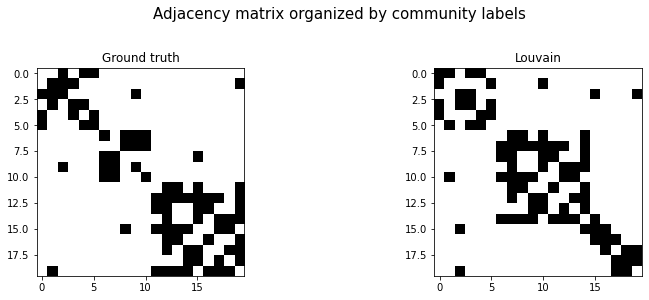

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
idxs = np.concatenate(list(community_true.values()))
plt.imshow(a[idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Ground truth')

plt.subplot(122)
idxs = np.concatenate(list(community_pred.values()))
plt.imshow(a[idxs][:, idxs], cmap='Greys', interpolation='antialiased')
plt.title('Louvain')

plt.suptitle('Adjacency matrix organized by community labels', fontsize=15, y=1.03)
plt.tight_layout()
plt.show()